<a href="https://colab.research.google.com/github/alneka/CUDA-training/blob/master/Detection_with_detectron2_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on how to use instance image segmentation recognition

## Part 1 Installation and setup

### Installation within Google Colab


First, check what kind of GPU Google is providing you in the current session. You find the GPU model name in the third row of the first column.

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Now onto the installation of all needed packages. Please keep in mind that this takes a few minutes.

In [ ]:
# install dependencies:
# (use +cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 41.8MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 276kB 4.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=863853942e89d75abfbcd2d289e4fcb7c83eef600c9801170ad84a9f76ee5ce4
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [ ]:
!pip install clodsa

     |████████████████████████████████| 5.7MB 7.0MB/s 
     |████████████████████████████████| 276kB 46.6MB/s 
  Created wheel for clodsa: filename=clodsa-1.2.39-py2.py3-none-any.whl size=72283 sha256=f33fd8967281a6593935060ea810f7e9c18ad992077c80edea014eeba91bc972
  Stored in directory: /root/.cache/pip/wheels/54/d4/a2/eb8df623c3fcd7d5d1045243fdf0ac1ccffa4f55090ef0e81b
  Created wheel for commentjson: filename=commentjson-0.8.3-cp36-none-any.whl size=11084 sha256=cf38f76d727a96d5ffbb9d3c5aca10dbdac2056ef9cfa09b336085cf03fa5bae
  Stored in directory: /root/.cache/pip/wheels/e1/bc/bc/dc8064582197c1b8e947a8b0191d36b3101096067b83b6af5f
  Created wheel for lark-parser: filename=lark_parser-0.7.8-py2.py3-none-any.whl size=62513 sha256=e521f1d62c8c4d1d23cba608aa6789a47ce1621f02eedab3118ecf4fba64695e
  Stored in directory: /root/.cache/pip/wheels/01/a2/30/ebae6ffa73cf3aa1c972a24d4c78388afd910f91e43bf554aa
Successfully built clodsa commentjson lark-parser


In [ ]:
# install detectron2:
!git clone https://github.com/facebookresearch/detectron2
!pip install -e detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 5761 (delta 10), reused 20 (delta 8), pack-reused 5730
Receiving objects: 100% (5761/5761), 2.64 MiB | 22.50 MiB/s, done.
Resolving deltas: 100% (4158/4158), done.
Obtaining file:///content/detectron2
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200623-cp36-none-any.whl size=41183 sha256=5b81661fbe0246b570f5d10ec416dc673efd8ce4056d8fc307f98b921965d914
  Stored in directory: /root/.cache/pip/wheels/31/b5/a9/df0fd43b263cc96c1d5076ade63fdcdd30fab8699e3366a60c
  Created wheel for pycocotools: filename=pycocotools-2.0.1-cp36-cp36m-linux_x86_64.whl size=267025 sha256=ad33bef214224be81b842689a12e3281b814a03e50863720a20a5dab4c5bee91
  Stored in directory: /root/.cache/pip/wheels/86/19/08/49b25f258ead1f861c9ab2fc41f73636f2928859adbb0e9797
Successfully built fvcore pycocotools
  Found existing installation: pyc

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow


import os
import json
import matplotlib.pyplot as plt

#For creative dataset
from datetime import datetime
import pickle
from pathlib import Path
from tqdm import tqdm

import imutils
from imutils import contours
import argparse

import glob

from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.transformers.transformerFactory import transformerGenerator
from clodsa.techniques.techniqueFactory import createTechnique
import xml.etree.ElementTree as ET
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## Part 2 - Training and Inferencing


### Import more packages

For the following code, we need to import additional packages.

In [ ]:
!unzip data.zip


Archive:  data.zip
   creating: data/train/
  inflating: data/train/1.jpg        
  inflating: data/train/10.jpg       
  inflating: data/train/11.jpg       
  inflating: data/train/14.jpg       
  inflating: data/train/15.jpg       
  inflating: data/train/18.jpg       
  inflating: data/train/2.jpg        
  inflating: data/train/20.jpg       
  inflating: data/train/21.jpg       
  inflating: data/train/22.jpg       
  inflating: data/train/23.jpg       
  inflating: data/train/24.jpg       
  inflating: data/train/25.jpg       
  inflating: data/train/26.jpg       
  inflating: data/train/27.jpg       
  inflating: data/train/28.jpg       
  inflating: data/train/29.jpg       
  inflating: data/train/3.jpg        
  inflating: data/train/30.jpg       
  inflating: data/train/31.jpg       
  inflating: data/train/32.jpg       
  inflating: data/train/33.jpg       
  inflating: data/train/34.jpg       
  inflating: data/train/35.jpg       
  inflating: data/train/4.jpg        
  infl

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import random
from datetime import datetime
import pickle
from pathlib import Path
from tqdm import tqdm

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode

## `Custon dataset creative`

In [ ]:
#Transfom

Exception="Image.jpg"
def multiply_image(image,R,G,B, Folder_name , img_file_name):
    image=image*[R, G, B]
    cv2.imwrite(Folder_name + img_file_name + "Multiply-"+str(R)+str(G)+str(B)+Exception, image)
def gausian_blur(image, blur, Folder_name , img_file_name):
    image=cv2.GaussianBlur(image,(5,5), blur)
    cv2.imwrite(Folder_name + img_file_name + "GaussianBlur-"+str(blur)+Exception, image)
def averageing_blur(image, shift, Folder_name , img_file_name):
    image=cv2.blur(image,(shift, shift))
    cv2.imwrite(Folder_name + img_file_name + "AverageingBlur-"+str(shift)+Exception, image)
def rotate_image(image, angle, Folder_name , img_file_name):
    rows, cols, pixs = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT,
                           borderValue=(255,255,255))
    cv2.imwrite(Folder_name + img_file_name + "Rotation-" + str(angle) + Exception, image)
def crop_image(image, size_h, size_w, Folder_name , img_file_name):
    size_h_ = round(size_h/2)
    size_w_ = round(size_w/2)
    x, y, _ = image.shape
    center_x = round(x/2)
    center_y = round(y/2)
    image = image[center_x-size_h_:center_x+size_h_, center_y-size_w_:center_y+size_w_, :]
    cv2.imwrite(Folder_name + img_file_name + "Crop-" + str(size_h) + 'x' +str(size_w) + Exception, image)


In [ ]:
def createImageData(Folder_name, path_name):
    for img, file in  enumerate(path_name.glob("*.jpg")):
            # this loop opens the .jpg files from the val-folder, creates a dict with the file
        # information, plots visualizations and saves the result as .pkl files.
        file = str(file)
        img_file_name = file.split("/")[-1]

        image = cv2.imread(file)
        crop_image(image, 40,40, Folder_name , img_file_name)
        multiply_image(image,1.25,1,1, Folder_name , img_file_name)
        multiply_image(image,1.5,1.5,1.5, Folder_name , img_file_name)
        gausian_blur(image, 0.50, Folder_name , img_file_name)
        averageing_blur(image, 4, Folder_name , img_file_name)
        i=0
        for i in range(35):
            rotate_image(image, i*10, Folder_name , img_file_name)




In [ ]:
path_name_train = Path("/content/data/train/")
Folder_name_train = r'/content/data/train/'
path_name_val = Path("/content/data/val/")
Folder_name_val = r'/content/data/val/'


In [ ]:

createImageData(Folder_name_train, path_name_train)
createImageData(Folder_name_val, path_name_val)

Create Annotaion from image + FindContour()

In [ ]:
import pycocotools.mask as mask_util

In [ ]:
#path_name = Path("/content/data/val/")
#Folder_name = r'/content/data/val/'

def tmp_annotation(path_name, Folder_name):
    labels_info = []
    for img, file in  enumerate(path_name.glob("*.jpg")):
            # this loop opens the .jpg files from the val-folder, creates a dict with the file
            # information, plots visualizations and saves the result as .pkl files.
            file = str(file)
            img_file_name = file.split("/")[-1]

            regions = []
            region_attributes = []
            shape_attributes = []

            #Read input image
            img = cv2.imread(file)

            #convert from BGR to HSV color space
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            #apply threshold
            thresh = cv2.threshold(gray, 35, 255, cv2.THRESH_BINARY)[1]

            # find contours and get one with area

            thresh = np.ascontiguousarray(thresh)
            # draw all contours in green and accepted ones in red
            contours,hierarchy = cv2.findContours(thresh.astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            #contours = contours[0] if len(contours) == 2 else contours[1]
            #area_thresh = 0
            #hierarchy = contours[-1]
            #if hierarchy is None:  # empty mask
            #    return [], False
            segmentation = []
            result = img.copy()
            has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
            #contours = contours[-2]
            #contours = [x.flatten() for x in contours]
            #contours = [x for x in contours if len(x) >= 6 ]

            for contour in contours:
                #area = cv2.contourArea(contour)
                #if area > 1000:
                #cv2.drawContours(result, [contour], -1, (0, 0, 255), 1)
                    #contour = contour.flatten().tolist()

                contour = contour.flatten().tolist()
                if len(contour) > 4:
                     #polygons = contour.flatten().tolist()
            #contours = [np.asarray(x).reshape(-1) for x in contours]
                    segmentation.append(contour)

            #segmentation.append([np.asarray(x).reshape(-1) for x in contours])
                    shape_attributes.append({
                        "name": "polyline",
                        "poly": segmentation
                    })

                    regions.append({
                        "shape_attributes": shape_attributes,
                        "region_attributes": region_attributes,
                    })
    #(x1, y1,width, height) = cv2.boundingRect(contours)
            #c = max(contours, key=cv2.contourArea)
            #rect = cv2.minAreaRect(contours[0])
            #box = cv2.boxPoints(contours)

            #y2 = y1 + height
            #x2 = x1 + width
            #rect = cv2.minAreaRect(contours[0])

            #cx, cy = rect[0]
            #w, h = rect[1]
            #x_min = box_d[0, :]
            #x_max = box_d[1, :]
            #y_min = box_d[:, 0]
            #y_max = box_d[:, 1]


            #x_min = np.min(([point[0] for point in box if point[0]>=0]))
            #y_min = np.min(([point[1] for point in box if point[0]>=0]))
            #x_max = np.max(([point[0] for point in box if point[0]>=0]))
            #y_max = np.max(([point[1] for point in box if point[0]>=0]))
            #height = y_max - y_min
            #width = x_max - x_min
            contours = [x for x in contours if len(x) >= 6 ]
            height, width = cv2.imread(file).shape[:2]
            p = mask_util.frPyObjects(segmentation, height, width)

            #p = mask_util.frPyObjects(contours, height, width)
            p = mask_util.merge(p)
            bbox = mask_util.toBbox(p)
            bbox[2] += bbox[0]
            bbox[3] += bbox[1]
            labels_info.append(
                {   "filename": img_file_name,
                    "height" :  height,
                    "width"  :  width,
                    "regions": regions,
                    #"bbox": [x_min, y_min, x_max,y_max],
                    "bbox": bbox
                })

            # =((((
            #json_file = os.path.join(path_name, "seg_mask.json")
            #with open(json_file, 'w') as f:
            #   json.dump(labels_info, f)
    return labels_info


In [ ]:
path_name_train = Path("/content/data1/train/")
Folder_name_train = r'/content/data1/train/'
path_name_val = Path("/content/data/val/")
Folder_name_val = r'/content/data/val/'


anno_buf_train = tmp_annotation(path_name_train, Folder_name_train)
#anno_buf_val = tmp_annotation(path_name_val, Folder_name_val)

In [ ]:
anno_buf_train

In [ ]:
def get_data_dicts_v3(img_dir):
    """This function loads the custon created with the annotator and converts it to
    the detectron2 metadata specifications.
    """
    imgs_anns = []
    if img_dir=="/content/data/train/":
        path_name = Path("/content/data/train/")
        Folder_name = r'/content/data/train/'
        #imgs_anns = tmp_annotation(path_name_train, Folder_name_train)
    else:
        path_name = Path("/content/data/val/")
        Folder_name = r'/content/data/val/'
        #imgs_anns = tmp_annotation(path_name_val, Folder_name_val)

    i=0
    dataset_dicts = []
    for img, file in  enumerate(path_name.glob("*.jpg")):
            # this loop opens the .jpg files from the val-folder, creates a dict with the file
            # information, plots visualizations and saves the result as .pkl files.
            file = str(file)
            filename = file.split("/")[-1]
            filename = str(path_name)+"/"+filename
            record = {}
            # add file_name, image_id, height and width information to the records
            #filename = os.path.join(img_dir, v["filename"])
            height, width = cv2.imread(file).shape[:2]

            record["file_name"] = filename
            idx = "idx_" + str(i)
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width

            #Read input image
            img = cv2.imread(file)
            #convert from BGR to HSV color space
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #apply threshold
            thresh = cv2.threshold(gray, 35, 255, cv2.THRESH_BINARY)[1]
            # find contours and get one with area
            thresh = np.ascontiguousarray(thresh)
            # draw all contours in green and accepted ones in red
            contours,hierarchy = cv2.findContours(thresh.astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            #contours = contours[0] if len(contours) == 2 else contours[1]


            #result = img.copy()
            objs = []
            for contour in contours:
                contour = contour.flatten().tolist()

                if len(contour) > 4:
                    segmentation = []
                    segmentation.append(contour)

                    p = mask_util.frPyObjects(segmentation, height, width)

                    #p = mask_util.frPyObjects(contours, height, width)
                    p = mask_util.merge(p)
                    bbox = mask_util.toBbox(p)
                    bbox[2] += bbox[0]
                    bbox[3] += bbox[1]



                    obj = {
                        "bbox": bbox,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "segmentation": segmentation,
                        "category_id": 0,
                        "iscrowd": 0,
                    }

                    objs.append(obj)

            record["annotations"] = objs
            dataset_dicts.append(record)

    return dataset_dicts

### Read the output `JSON`-file from the VGG Image Annotator

This function is needed to read the annotations for all the images correctly. It also converts them into a format that is usable by `detectron2`. If you have additional information, like other target classes, you need to change the function accordingly.

In [ ]:
def get_data_dicts_v2(img_dir):
    """This function loads the custon created with the annotator and converts it to
    the detectron2 metadata specifications.
    """
    imgs_anns = []
    if img_dir=="/content/data/train/":
        path_name_train = Path("/content/data/train/")
        Folder_name_train = r'/content/data/train/'
        imgs_anns = tmp_annotation(path_name_train, Folder_name_train)
    else:
        path_name_val = Path("/content/data/val/")
        Folder_name_val = r'/content/data/val/'
        imgs_anns = tmp_annotation(path_name_val, Folder_name_val)


    dataset_dicts = []
    # loop through the entries in the JSON file
    for idx, v in enumerate(imgs_anns):
        record = {}
        # add file_name, image_id, height and width information to the records
        filename = os.path.join(img_dir, v["filename"])
        #height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = int(v["height"])
        record["width"] = int(v["width"])

        annos = v["regions"]

        objs = []

        # one image can have multiple annotations, therefore this loop is needed
        for annotation in annos:
         #    for _, anno in annos.items():
               #  assert not anno["region_attributes"]
            #anno = annotation["shape_attributes"]

            px = [r['poly'] for r in annotation["shape_attributes"]]
            #px = anno["poly"]

            region_attributes = [r["class"] for r in annotation["region_attributes"]]

            # specify the category_id to match with the class.

            if "1" in region_attributes:
                category_id = 1
            elif "0" in region_attributes:
                category_id = 0

            obj = {
                "bbox": v["bbox"],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": px,
                "category_id": 0,
                "iscrowd": 0,
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [ ]:
def get_data_dicts(img_dir):
    """This function loads the JSON file created with the annotator and converts it to
    the detectron2 metadata specifications.
    """
    # load the JSON file
    json_file = os.path.join(img_dir, "via_mask.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    # loop through the entries in the JSON file
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        # add file_name, image_id, height and width information to the records
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]

        objs = []
        # one image can have multiple annotations, therefore this loop is needed
        for annotation in annos:
         #    for _, anno in annos.items():
               #  assert not anno["region_attributes"]
            anno = annotation["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]


            region_attributes = annotation["region_attributes"]["class"]

            # specify the category_id to match with the class.

            if "1" in region_attributes:
                category_id = 1
            elif "0" in region_attributes:
                category_id = 0

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
                "iscrowd": 0,
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

### Prepare the data

You need to load and prepare the data. Therefore, use the code below for the training and validation data.

In [ ]:
# the data has to be registered within detectron2, once for the train and once for
# the val data
for d in ["train", "val"]:
    DatasetCatalog.register(
        "data_" + d,
        lambda d=d: get_data_dicts_v3("/content/data/" + d ),
    )



In [ ]:
tmp_json= pd.read_json("/content/data/val/via_mask.json")
tmp_json.transpose().reset_index()[['filename','regions']]

## Register dataset:


In [ ]:
data_metadata = MetadataCatalog.get("data_train")

dataset_dicts = get_data_dicts_v3("/content/data/train/")

In [ ]:
dataset_dicts

[{'annotations': [{'bbox': array([   0.,    0., 1023.,  767.]),
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0,
    'segmentation': [[0, 0, 0, 767, 1023, 767, 1023, 0]]},
   {'bbox': array([307.,  43., 845., 631.]),
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0,
    'segmentation': [[368,
      44,
      369,
      43,
      374,
      43,
      375,
      44,
      378,
      44,
      379,
      43,
      380,
      44,
      381,
      44,
      382,
      43,
      383,
      43,
      384,
      44,
      385,
      43,
      386,
      44,
      386,
      45,
      391,
      45,
      392,
      44,
      396,
      44,
      397,
      45,
      401,
      45,
      402,
      44,
      405,
      44,
      406,
      45,
      408,
      45,
      409,
      44,
      410,
      44,
      411,
      45,
      412,
      44,
      413,
      44,
      414,
      45,
      415,
      45,
      416,
      44,
     

### View the input data

To check if everything is working as intended, you can view some of the input data before continuing. You should see two images, with bounding boxes around windows and buildings, where the buildings have a `1` as category and windows a `0`. Try it a few times; if you have images in your `JSON`-annotation file that you have not yet annotated, they show without any annotations. `detectron2` skips these in training.

In [ ]:
!mkdir inputs

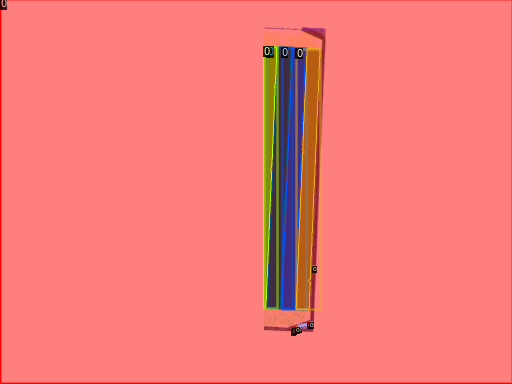

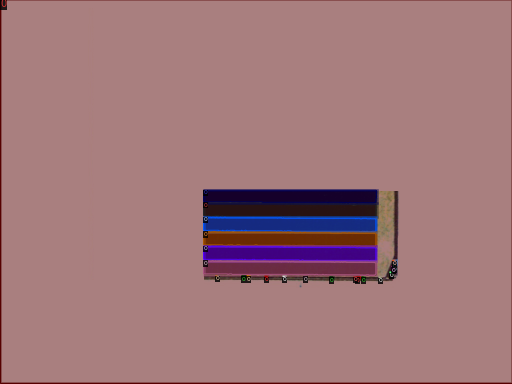

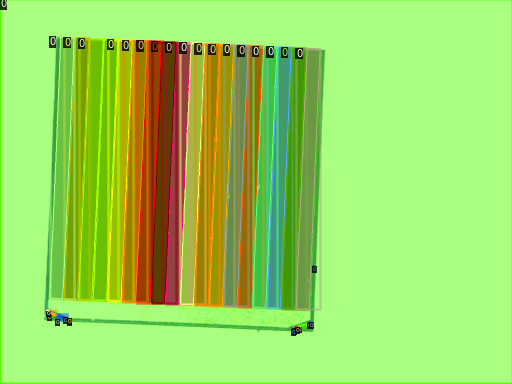

In [ ]:
for i, d in enumerate(random.sample(dataset_dicts, 3)):
    # read the image with cv2
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=data_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])
    # if you want to save the files, uncomment the line below, but keep in mind that
    # the folder inputs has to be created first
    #plt.savefig(f"./inputs/input_{i}.jpg")

### Configure the `detectron2` model

Now we need to configure our `detectron2` model before we can start training. There are more possible parameters to configure. For more information, you can visit the [detectron2 documentation](https://detectron2.readthedocs.io/modules/config.html). The maximum of iterations is calculated by multiplying the amount of epochs times the amount of images times the images per batch. You can try larger values for the learning rate. A larger learning rate might result in better results in a shorter amount of training time. Otherwise, to get good results, increase the number of iterations (150.000 worked well for me). And most importantly: create additional data to improve the results!

### NOT

In [ ]:
cfg = get_cfg()
# you can choose alternative models as backbone here
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
))

cfg.DATASETS.TRAIN = ("data_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
# if you changed the model above, you need to adapt the following line as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR, 0.00025 seems a good start
cfg.SOLVER.MAX_ITER = (
    1000  # 1000 iterations is a good start, for better accuracy increase this value
)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    512  # (default: 512), select smaller if faster training is needed
)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # for the two classes window and building


In [ ]:
MODEL_USE = "faster_rcnn"
if MODEL_USE == "faster_rcnn":

    MODEL_PATH = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
    WEIGHT_PATH = "model_final_f6e8b1.pkl"
elif MODEL_USE == "retinanet":
    MODEL_PATH = "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
    WEIGHT_PATH = "model_final_971ab9.pkl" # Previously pretrained on 10000 iterations
elif MODEL_USE == "mask_rcnn":
    MODEL_PATH = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
    WEIGHT_PATH = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
elif MODEL_USE == "cascade_mask_rcnn":
    MODEL_PATH = "Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"
    WEIGHT_PATH = "model_final_480dd8.pkl"

def cfg_setup():

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
    cfg.MODEL.WEIGHTS = WEIGHT_PATH # model_zoo.get_checkpoint_url(WEIGHT_PATH)
    cfg.MODEL.RETINANET.NUM_CLASSES = 2
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

    cfg.DATASETS.TRAIN = ("data_train",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 4

    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
    cfg.SOLVER.BASE_LS = 0.0002
#     cfg.SOLVER.WARMUP_ITERS = 4500
#     cfg.SOLVER.WARMUP_METHOD = "linear"
    cfg.SOLVER.MAX_ITER = 500
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    return cfg

In [ ]:
cfg = cfg_setup()

### Start training

The next four lines of code create an output directory, a `trainer`, and start training. If you only want to inference with an existing model, skip these four lines.

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: ignored

### Inferencing for new data

For inferencing, we need to load the final model created by the training and load the validation data set, or any data set that you wish to inference on. Also, two folders have to be created within Google Colab. Be aware that depending on the amount of `iterations` and the chosen `threshold`, some or all images may show no predicted annotations. In that case, you have to adapt your configuration accordingly.

In [ ]:
!mkdir predictions
!mkdir output_images

## NOT

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
    0.70  # set the testing threshold for this model
)

# load the validation data
cfg.DATASETS.TEST = ("data_val",)

## `ALTERNATIVE`

In [ ]:
def cfg_test():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
    0.70  # set the testing threshold for this model
)
    cfg.DATASETS.TEST = ("data_val",)
    cfg.MODEL.RETINANET.NUM_CLASSES = 2
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

    return cfg
cfg = cfg_test()

Time needed for inferencing: 0:00:15.969177


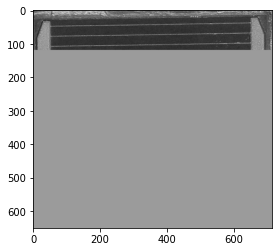

In [ ]:

# create a predictor
predictor = DefaultPredictor(cfg)

start = datetime.now()

validation_folder = Path("/content/data/val")

for i, file in enumerate(validation_folder.glob("*.jpg")):
    # this loop opens the .jpg files from the val-folder, creates a dict with the file
    # information, plots visualizations and saves the result as .pkl files.
    file = str(file)
    file_name = file.split("/")[-1]
    im = cv2.imread(file)

    outputs = predictor(im)
    output_with_filename = {}
    output_with_filename["file_name"] = file_name
    output_with_filename["file_location"] = file
    output_with_filename["prediction"] = outputs
    # the following two lines save the results as pickle objects, you could also
    # name them according to the file_name if you want to keep better track of your data
    with open(f"/content/predictions/predictions_{i}.pkl", "wb") as f:
        pickle.dump(output_with_filename, f)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=data_metadata,
        scale=1,
        instance_mode=ColorMode.IMAGE_BW,  # remove the colors of unsegmented pixels
    )

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.savefig(f"/content/output_images/{file_name}")
print("Time needed for inferencing:", datetime.now() - start)

## Part 3 - Processing the prediction results

### Importing of additional packages

For processing our results, we need to import a few additional packages.

In [ ]:
import pickle
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import multiprocessing as mp
from tqdm import tqdm
from datetime import datetime

import pandas as pd

### Set some general colour and font settings

We download a font for displaying text on our images and set a few colors. They are in RGBA-format, so change values as you wish. If you do not require plotting the results as
images, set `plot_data` to False, thereby **decreasing computation time by 5x**.

In [ ]:
!wget https://github.com/google/fonts/raw/master/apache/roboto/Roboto-Regular.ttf

In [ ]:
!wget https://github.com/cf-platform-eng/springtrader-cf/blob/master/spring-nanotrader-web/src/main/webapp/fonts/colaborate-medium-webfont.ttf

In [ ]:
# define fonts and colors
#font_id = ImageFont.load("arial.pil")
font_id = ImageFont.truetype("/content/RobotoMono-Regular.ttf", 15)
font_result = ImageFont.truetype("/content/RobotoMono-Regular.ttf", 40)
text_color = (255, 255, 255, 128)
background_bbox_ph_area = (0, 247, 255, 30)
background_bbox_cell = (255, 167, 14, 30)
background_text = (0, 0, 0, 150)
background_mask_ph_area = (0, 247, 255, 100)
background_mask_cell = (255, 167, 14, 100)
device = "cpu"

# this variable is True if you want to plot the output images, False if you only need
# the CSV
plot_data = True

### Function to draw a bounding box

This function draws a bounding box as well as the window to facade percentage.

In [ ]:
def draw_bounding_box(img, bounding_box, text, category, id, draw_box=False):
    """Draws a bounding box onto the image as well as the building ID and the window
    percentage."""

    x = bounding_box[0]
    y = bounding_box[3]
    text = str(round(text, 2))
    draw = ImageDraw.Draw(img, "RGBA")
    # draw_box will draw the bounding box as seen in the outputs of detectron2
    if draw_box:
        if category == 0:
            draw.rectangle(bounding_box, fill=background_bbox_ph_area, outline=(0, 0, 0))
        elif category == 1:
            draw.rectangle(
                bounding_box, fill=background_bbox_cell, outline=(0, 0, 0)
            )
    w, h = font_id.getsize(id)

    draw.rectangle((x, y, x + w, y - h), fill=background_text)
    draw.text((x, y - h), id, fill=text_color, font=font_id)
    # for buildings, add the window percentage value in the lower right corner
    #if category == 1:
    #    w, h = font_result.getsize(text)
    #    draw.rectangle((x, y, x + w, y + h), fill=background_text)
    #    draw.text((x, y), text, fill=text_color, font=font_result)

### Function to draw masks

This function draws masks to the image. The binary NumPy masks consisting of `True/False` for each pixel value of the image are converted to `RGBA` image files.

In [ ]:
def draw_mask(img, mask, category):
    """Draws a mask onto the image."""

    img = img.convert("RGBA")

    mask_RGBA = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)

    if category == 0:
        mask_RGBA[mask] = background_mask_ph_area
    elif category == 1:
        mask_RGBA[mask] = background_mask_cell

    mask_RGBA[~mask] = [0, 0, 0, 0]
    rgb_image = Image.fromarray(mask_RGBA).convert("RGBA")

    img = Image.alpha_composite(img, rgb_image)

    return img

### Calculate the percentage of window to facade

This function takes the results of the predictions and sums up all window-pixels within a building. The sum is then divided by the total amount of building pixel area of the respective building.

In [ ]:
def calculate_ph_area_perc(dataset):
    """Takes a list of prediction dictionaries as input and calculates the percentage of
    window to fassade for each cell. The result is save to the dataset. For cell
    data, the actual percentage is saved, for windows, 1.0 is put in."""
    with open("/content/data/val/via_mask.json") as f:
        json_file = json.load(f)
    for i, data in enumerate(dataset):
        data["ph_area_percentage"] = 0
        data["pixel_area"] = 0
        data["tagged_id"] = 0
        # loop through building
        if data["category"] == 1:
            data = get_tagged_id(data, json_file)
            ph_area_areas = []
            cell_mask = data["mask"]
            cell_area = np.sum(data["mask"])

            for ph_area in dataset:
                # for each building, loop through each window
                if ph_area["category"] == 0:
                    ph_area["ph_area_percentage"] = 1
                    pixels_overlapping = np.sum(ph_area["mask"][cell_mask])

                    ph_area_areas.append(pixels_overlapping)

            ph_area_percentage = sum(ph_area_areas) / cell_area

            data["ph_area_percentage"] = ph_area_percentage
            data["pixel_area"] = cell_area

    return dataset

### Get Tagged IDs for the Buildings
The following function searches through the `via_region_data.json` file for any points that have a `tagged_id` category, and if such a point matches with a predicted building mask, the `tagged_id` and point location is added to the building.

In [ ]:
def get_tagged_id(cell, json_file):
    """Searches through the via_export_json.json of the images used for inferencing and
    adds all tagged_ids to the dataset."""

    cell["tagged_id"] = 0
    cell["tagged_id_coords"] = 0
    # loop through the JSON annotations file
    for idx, v in enumerate(json_file.values()):
        annos = v["regions"]

        if v["filename"] == cell["file_name"]:
            try:
                for annotation in annos:
                    anno = annotation["shape_attributes"]
                    # if the annotation is not a point, go to the next annotation
                    if anno["name"] != "point":
                        continue

                    if anno["name"] == "point":
                        tagged_id = annotation["region_attributes"]["tagged_id"]
                        px = anno["cx"]
                        py = anno["cy"]
                        point = [py, px]

                        # if the point location matches with the cell mask, add the
                        # id to the cell data
                        if cell["mask"][py][px]:
                            cell["tagged_id"] = tagged_id
                            cell["tagged_id_coords"] = point

            except KeyError as e:
                print("Error:", e)
                return cell

    return cell

### Save the building information to a CSV

This function saves the results for the buildings and their percentage values into a CSV-file, which you can then use for further processing or modeling.

In [ ]:
def create_csv(dataset):
    """Takes a list of lists of data dictionaries as input, flattens this list, creates
    a DataFrame, removes unnecessary information and saves it as a CSV."""

    # flatten list
    dataset = [item for sublist in dataset for item in sublist]
    df = pd.DataFrame(dataset)


    # calculate the percentage of the cell compared to the total image size
    df["total_image_area"] = df["image_height"] * df["image_width"]
    df["cell_area_perc_of_image"] = df["pixel_area"] / df["total_image_area"]
    # keep only specific columns
    df = df[
        [
            "file_name",
            "id",
            "tagged_id",
            "tagged_id_coords",
            "category",
            "pixel_area",
            "cell_area_perc_of_image",
            "ph_area_percentage",
        ]
    ]
    # only keep cell information
    df = df[df["category"] == 1]


    df.to_csv("/content/result.csv")
    return(df)

### Function to process all the data

This function processes the results from the prediction and applies all the processing functions from above. Bounding boxes and masks are drawn, the window percentage calculated, and the resulting dicts with all the information are returned.

In [ ]:
def process_data(file_path, plot_data=plot_data):
    """Takes an prediction result in form of a .pkl-file and draws the mask and bounding
    box information. From these, the percentage of ph_areas to fassade for each cell
    is calculated and plotted onto the image if plot_data=True."""
    with open(file_path, "rb") as f:
        # the following lines of code extract specific data from the prediction-dict
        prediction = pickle.load(f)

        image_height = prediction["prediction"]["instances"].image_size[0]
        image_width = prediction["prediction"]["instances"].image_size[1]

        # the data is still saved on the GPU and needs to be moved to the CPU
        boxes = (
            prediction["prediction"]["instances"]
            .get_fields()["pred_boxes"]
            .tensor.to(device)
            .numpy()
        )

        img = Image.open(prediction["file_location"])
        categories = (
            prediction["prediction"]["instances"]
            .get_fields()["pred_classes"]
            .to(device)
            .numpy()
        )
        masks = (
            prediction["prediction"]["instances"]
            .get_fields()["pred_masks"]
            .to(device)
            .numpy()
        )

        dataset = []
        counter_ph_area = 0
        counter_cell = 0
        # create a new data-dict as well as IDs for each cell and ph_area within an
        # image
        for i, box in enumerate(boxes):
            data = {}
            data["file_name"] = prediction["file_name"]
            data["file_location"] = prediction["file_location"]
            data["image_height"] = image_height
            data["image_width"] = image_width
            # category 0 is always a ph_area
            if categories[i] == 0:
                data["id"] = f"w_{counter_ph_area}"
                counter_ph_area = counter_ph_area + 1
            # category 1 is always a cell
            elif categories[i] == 1:
                data["id"] = f"b_{counter_cell}"
                counter_cell = counter_cell + 1

            data["bounding_box"] = box
            data["category"] = categories[i]
            data["mask"] = masks[i]
            dataset.append(data)

        dataset = calculate_ph_area_perc(dataset)

        if plot_data:
            for i, data in enumerate(dataset):
                draw_bounding_box(
                    img,
                    data["bounding_box"],
                    data["ph_area_percentage"],
                    data["category"],
                    data["id"],
                    draw_box=True,
                )
            for i, data in enumerate(dataset):
                img = draw_mask(img, data["mask"], data["category"])
            try:
              img.save(
                  f"/content/predictions/{data['file_name']}_prediction.png",
                  quality=95,
              )
            except UnboundLocalError as e:
              print("no annotations found, skipping")
    return dataset

### Use multiple CPU Cores for processing
This does not work well with Google Colab, but on a local machine with multiple CPU cores, this would speed up processing quite a bit.

In [ ]:
def apply_mp_progress(func, n_processes, prediction_list):
    """Applies multiprocessing to a list of data. Currently does not work well in Google
    Collab."""

    p = mp.Pool(n_processes)

    res_list = []
    with tqdm(total=len(prediction_list)) as pbar:
        for i, res in tqdm(enumerate(p.imap_unordered(func, prediction_list))):
            pbar.update()
            res_list.append(res)
        pbar.close()
    p.close()
    p.join()
    return res_list

### Run the processing

This last piece of code runs the processing of the results and saves it as a CSV file.

In [ ]:
prediction_folder = Path("/content/predictions/")
prediction_list = []
start = datetime.now()
for i, file in enumerate(prediction_folder.glob("*.pkl")):
    file = str(file)
    prediction_list.append(file)


# this is for processing on a single CPU in Colab
dataset = []

for file_location in tqdm(prediction_list):
  dataset_part = process_data(file_location)
  dataset.append(dataset_part)



 50%|█████     | 7/14 [00:01<00:01,  3.61it/s]

no annotations found, skipping
no annotations found, skipping


100%|██████████| 14/14 [00:04<00:00,  3.49it/s]


In [ ]:
dataset

[[{'bounding_box': array([710.1646 , 388.11975, 795.8162 , 567.2258 ], dtype=float32),
   'category': 1,
   'file_location': '/content/data/val/11.jpg',
   'file_name': '11.jpg',
   'id': 'b_0',
   'image_height': 768,
   'image_width': 1024,
   'mask': array([[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]),
   'ph_area_percentage': 0.42483792544570503,
   'pixel_area': 14808,
   'tagged_id': 'id_11',
   'tagged_id_coords': [470, 764]},
  {'bounding_box': array([715.9735 , 383.12198, 765.4002 , 556.8613 ], dtype=float32),
   'category': 0,
   'file_location': '/content/data/val/11.jpg',
   'file_name': '11.jpg',
   'id': 'w_0',
   'image_height': 768,
   'image_width': 1024,
   '

In [ ]:
# If you use this code on a local machine, comment out the four lines above and uncomment
# the line below
# dataset = apply_mp_progress(process_data, mp.cpu_count(), prediction_list)


df = create_csv(dataset)

print(datetime.now() - start)
df

0:00:17.761487


,file_name,id,tagged_id,tagged_id_coords,category,pixel_area,cell_area_perc_of_image,ph_area_percentage
0,11.jpg,b_0,id_11,"[470, 764]",1,14808,0.018829,0.424838
2,2.jpg,b_0,id_2,"[509, 485]",1,59923,0.076196,0.300469
6,4.jpg,b_0,id_4,"[507, 489]",1,48376,0.061513,0.577352
13,9.jpg,b_0,id_9,"[477, 484]",1,104927,0.133422,0.779456
15,3.jpg,b_0,id_3,"[506, 257]",1,12063,0.015339,0.151621
21,5.jpg,b_0,id_5,"[152, 360]",1,169297,0.315774,0.568663
23,21.jpg,b_0,id_21,"[344, 386]",1,435564,0.726332,0.000000
37,8.jpg,b_0,id_8,"[277, 493]",1,337535,0.429198,0.704416
42,22.jpg,b_0,id_22,"[296, 345]",1,415658,0.896878,0.000000
43,6.jpg,b_0,id_6,"[479, 379]",1,148146,0.276323,0.618363


### Downloading Results to the local Machine
You might want to download your results, primarily because all files created in this Colab notebook are temporary and deleted after 12 hours. The following code creates a zip file for a directory and all its content and then opens up a download-dialog. For the download to work, you need to accept third-party cookies, and you also need to use the `Chrome` browser from Google.

In [ ]:
!zip -r predictions.zip predictions


  adding: predictions/ (stored 0%)
  adding: predictions/predictions_9.pkl (deflated 100%)
  adding: predictions/22.jpg_prediction.png (deflated 1%)
  adding: predictions/predictions_3.pkl (deflated 100%)
  adding: predictions/3.jpg_prediction.png (deflated 12%)
  adding: predictions/23.jpg_prediction.png (deflated 1%)
  adding: predictions/10.jpg_prediction.png (deflated 11%)
  adding: predictions/predictions_2.pkl (deflated 100%)
  adding: predictions/9.jpg_prediction.png (deflated 4%)
  adding: predictions/2.jpg_prediction.png (deflated 5%)
  adding: predictions/21.jpg_prediction.png (deflated 1%)
  adding: predictions/predictions_7.pkl (deflated 100%)
  adding: predictions/6.jpg_prediction.png (deflated 3%)
  adding: predictions/4.jpg_prediction.png (deflated 4%)
  adding: predictions/predictions_13.pkl (deflated 100%)
  adding: predictions/predictions_8.pkl (deflated 100%)
  adding: predictions/predictions_5.pkl (deflated 100%)
  adding: predictions/7.jpg_prediction.png (deflated 

In [ ]:
from google.colab import files
files.download('/content/predictions.zip')